In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.utils import resample

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer
from aif360.algorithms.preprocessing.reweighing import Reweighing

import json

from sklearn.preprocessing import StandardScaler, scale
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score

from IPython.display import Markdown, display
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[LFR]'


<a id='main'></a>

### Steps in the Data Science Pipeline

1. Data Preparation  
    a. [Allstate datasets](#allstate_datasets)  
    b. [American Community Survey (ACS) dataset](#acs_dataset)
2. [Exploratory Data Analysis](#data_expo)  
    a. [Relationships with Change in Premium](#change_in_prem)  
    b. [Distribution of Change in Premium by Risk Group](#risk_grp)
3. [Features Engineering](#features)  
    a. [Upsample for modelling dataset](#upsample)
4. Bias Detection and Mitigation  
    a. [Bias Detection](#find_bias)  
    b. [Bias Mitigation](#fix_bias)  
5. [Modelling](#data_model)  
    a. [Optimize features](#optimize_features)
6. [Tradeoffs](#tradeoffs)

<a id='allstate_datasets'></a>

### 1. Data Preparation

Source: https://github.com/the-markup/investigation-allstates-algorithm/tree/master/data/csv

### 1a. Allstate datasets

In [2]:
df1 = pd.read_csv('../data/allstate/cgr-premiums-table.csv')

In [3]:
df2 = pd.read_csv('../data/allstate/territory-definitions-table.csv')

In [4]:
# remove dupe territories
df2 = df2[~df2['territory'].duplicated()].copy()

In [5]:
df2.reset_index(drop=True, inplace=True)

In [6]:
df = df1.merge(df2, on='territory', suffixes=('', ''))

In [7]:
df.shape

(92792, 17)

<a id='acs_dataset'></a>

[Go to top](#main)

### 1b. ACS dataset

In [8]:
# get demographics
df3 = pd.read_csv('../data/allstate/ACS_MD_15_5YR_DP05.csv')

In [9]:
df3['population'] = df3['HC01_VC88'] + df3['HC01_VC94'] + df3['HC01_VC95'] + df3['HC01_VC96'] + df3['HC01_VC97'] + df3['HC01_VC98'] + df3['HC01_VC99']

In [10]:
df3['perc_nonwhite'] = 100 * (df3['population'] - df3['HC01_VC94']) / df3['population']

In [11]:
# remove missing data
df3 = df3[~df3['perc_nonwhite'].isna()].copy()

In [12]:
df3['majority_minority'] = df3['perc_nonwhite'] > 0.75

In [13]:
df3 = df3[['GEO.id2', 'population', 'perc_nonwhite', 'majority_minority']].copy()

In [14]:
df = df.merge(df3, left_on='zipcode', right_on='GEO.id2')

In [15]:
# NOTE: lost 5 policyholders w/ a match
df.shape

(92786, 21)

In [16]:
df.head()

,territory,gender,birthdate,ypc,current_premium,indicated_premium,selected_premium,underlying_premium,fixed_expenses,underlying_total_premium,...,cgr,county,county_code,zipcode,town,area,GEO.id2,population,perc_nonwhite,majority_minority
0,601,M,10/5/1947,0,863.97,830.58,862.57,673.06,175.98,849.04,...,ZHK,CHARLES,8,20601,WALDORF,210,20601,24233,58.758717,True
1,601,F,7/6/1953,0,828.63,611.14,826.43,612.75,175.98,788.73,...,6NS,CHARLES,8,20601,WALDORF,210,20601,24233,58.758717,True
2,601,M,4/18/1956,0,1000.59,593.99,996.60,858.20,175.98,1034.18,...,Z2D,CHARLES,8,20601,WALDORF,210,20601,24233,58.758717,True
3,601,F,8/16/1956,0,700.42,547.95,697.84,571.49,180.48,751.97,...,D7G,CHARLES,8,20601,WALDORF,210,20601,24233,58.758717,True
4,601,F,1/23/1957,0,505.92,448.33,504.56,333.71,152.08,485.79,...,3YN,CHARLES,8,20601,WALDORF,210,20601,24233,58.758717,True


<a id='data_expo'></a>

[Go to top](#main)

### 2. Exploratory Data Analysis

In [17]:
# definitions
# current premium ~ paying now
# indicated premium (ideal price) ~ should be paying
# selected premium (transition price) ~ retention-based (final premium)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92786 entries, 0 to 92785
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   territory                 92786 non-null  int64  
 1   gender                    92786 non-null  object 
 2   birthdate                 92786 non-null  object 
 3   ypc                       92786 non-null  int64  
 4   current_premium           92786 non-null  float64
 5   indicated_premium         92786 non-null  float64
 6   selected_premium          92786 non-null  float64
 7   underlying_premium        92786 non-null  float64
 8   fixed_expenses            92786 non-null  float64
 9   underlying_total_premium  92786 non-null  float64
 10  cgr_factor                92786 non-null  float64
 11  cgr                       92786 non-null  object 
 12  county                    92786 non-null  object 
 13  county_code               92786 non-null  int64  
 14  zipcod

In [19]:
today = pd.to_datetime('today').strftime('%m-%d-%Y')

#### Add Age

In [20]:
df['age'] = pd.to_datetime(today) - pd.to_datetime(df['birthdate'])

In [21]:
df['age'] = df['age'].dt.days / 365.2425

In [22]:
df['age_'] = df['age'].round().astype(int)

#### Add Change in Premium

In [23]:
df['change_in_premium'] = df['selected_premium'] - df['current_premium']

<AxesSubplot:xlabel='current_premium', ylabel='change_in_premium'>

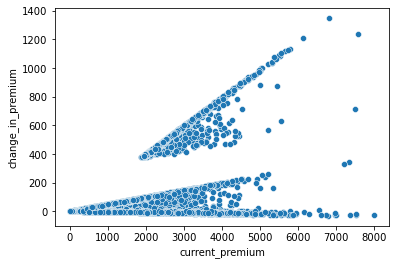

In [24]:
# clearly a bifurcation around change in premium of $400
sns.scatterplot(x='current_premium', y='change_in_premium', data=df)

#### Add Risk Group

In [25]:
# NOTE: two policies at 260.05
df['risk_group'] = np.where(df['change_in_premium'] <= 260.05, 0, 1)

In [26]:
df = df.join(pd.get_dummies(df['risk_group'], prefix='risk_group'))

In [27]:
df['risk_group'].value_counts(normalize=True)

0    0.980223
1    0.019777
Name: risk_group, dtype: float64

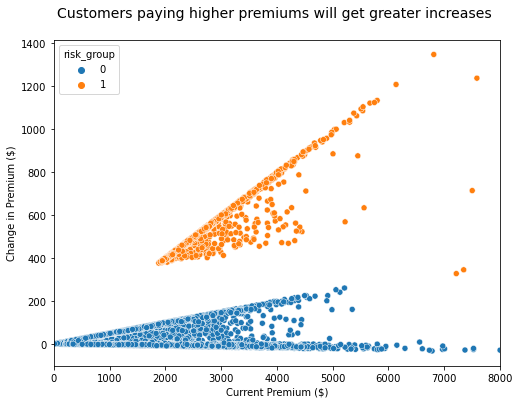

In [28]:
# clearly a bifurcation around change in premium of $260.05
plt.figure(figsize=(8,6))
plt.xlim([0,8000])

g = sns.scatterplot(x='current_premium', y='change_in_premium', hue='risk_group', data=df, legend='brief')

plt.xlabel('Current Premium ($)')
plt.ylabel('Change in Premium ($)')
plt.title('Customers paying higher premiums will get greater increases \n', fontsize=14)

plt.show()

<a id='change_in_prem'></a>

[Go to top](#main)

### 2a. Relationships with Change in Premium

#### Age

In [29]:
sns.reset_orig()

<AxesSubplot:>

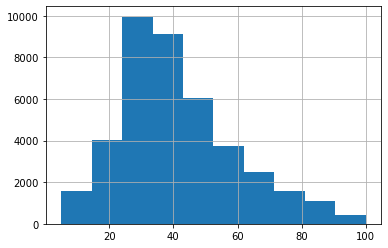

In [30]:
# majority of the values are between -10 and 10
# bimodal distribution – get the riskgroup 1 part
df['change_in_premium'].hist(range=[5,100])

In [31]:
df['age_group'] = pd.cut(df['age'], bins=[20, 40, 60, 80, 125], labels=['20-40', '40-60', '60-80', '80+'])

<AxesSubplot:xlabel='age_group'>

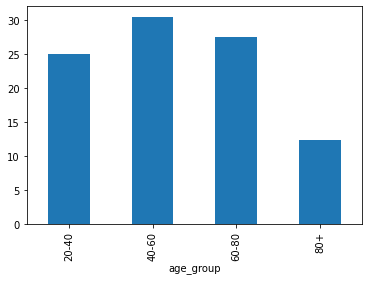

In [32]:
df.groupby('age_group')['change_in_premium'].mean().plot(kind='bar')

<AxesSubplot:xlabel='gender'>

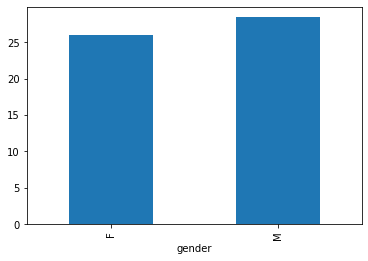

In [33]:
df.groupby('gender')['change_in_premium'].mean().plot(kind='bar')

<AxesSubplot:xlabel='ypc'>

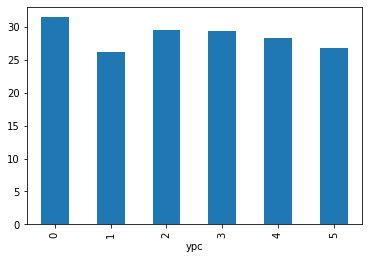

In [34]:
df.groupby('ypc')['change_in_premium'].mean().plot(kind='bar')

<a id='risk_grp'></a>

[Go to top](#main)

### 2b. Distribution of Change in Premium by Risk Group

In [35]:
df['current_premium_bucket'] = pd.cut(df['current_premium'], bins=[0,1000,2000,3000,4000,5000,10000], 
                                     labels=['Up to \$1000', '\$1000 to \$2000', '\$2000 to \$3000', 
                                             '\$3000 to \$4000', '\$4000 to \$5000', '\$5000+'])



In [36]:
cur_prem_counts = df.groupby('current_premium_bucket')['risk_group_0', 'risk_group_1'].agg({'count', 'sum'})

In [37]:
cur_prem_counts = cur_prem_counts.reset_index()

In [38]:
cur_prem_counts.columns = ['Current Premium Range', 'Total', 'Risk Group 0', 'Total', 'Risk Group 1']

In [39]:
cur_prem_counts['Total_'] = cur_prem_counts[['Total']].iloc[:,0]

In [40]:
cur_prem_counts.drop(columns={'Total'}, inplace=True)

In [41]:
cur_prem_counts.rename(columns={'Total_':'Total'}, inplace=True)

In [42]:
tot_riskgrp0 = cur_prem_counts['Risk Group 0'].sum()
tot_riskgrp1 = cur_prem_counts['Risk Group 1'].sum()

In [43]:
cur_prem_counts['% Risk Group 0'] = cur_prem_counts['Risk Group 0']/tot_riskgrp0 * 100
cur_prem_counts['% Risk Group 1'] = cur_prem_counts['Risk Group 1']/tot_riskgrp1 * 100

In [44]:
cur_prem_counts

,Current Premium Range,Risk Group 0,Risk Group 1,Total,% Risk Group 0,% Risk Group 1
0,Up to \$1000,57606,57606,57606.0,62.084797,62.084797
1,\$1000 to \$2000,28753,28753,28575.0,30.988511,30.988511
2,\$2000 to \$3000,5049,5049,3776.0,5.441554,5.441554
3,\$3000 to \$4000,1062,1062,774.0,1.144569,1.144569
4,\$4000 to \$5000,246,246,173.0,0.265126,0.265126
5,\$5000+,70,70,47.0,0.075442,0.075442


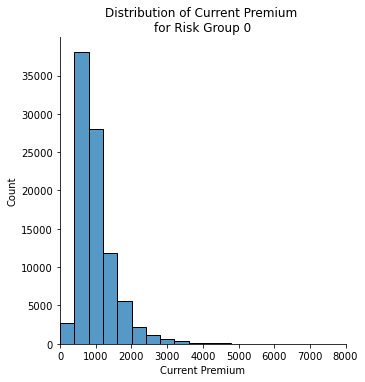

In [45]:
sns.displot(x='current_premium', data=df[df['risk_group_0'] == 1], bins=20, color='tab:blue')
plt.xlim([0,8000])
plt.xlabel('Current Premium')
plt.title('Distribution of Current Premium \nfor Risk Group 0')
plt.show()

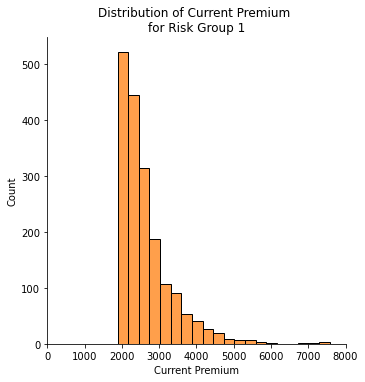

In [46]:
sns.displot(x='current_premium', data=df[df['risk_group_1'] == 1], bins=20, color='tab:orange')
plt.xlim([0,8000])
plt.xlabel('Current Premium')
plt.title('Distribution of Current Premium \nfor Risk Group 1')
plt.show()

<a id='features'></a>

[Go to top](#main)

### 3. Features engineering

#### Assumption: All policyholders are unique in effect ignoring policyholders with the same birthdate and gender

In [47]:
pd.set_option('min_rows', 100)
pd.set_option('display.max_columns', 50)

#### Convert Current Premium to integer

In [48]:
df['current_premium_int'] = df['current_premium'].round().astype(int)

#### Convert Age into categorical variables

In [49]:
df['age_group'] = pd.cut(df['age_'], bins=[20,40,60,80,100,150], labels=['young', 'middle-aged', 'senior',
                                                                        'retired', 'old'])

In [50]:
df = pd.concat([df, pd.get_dummies(df['age_group'], drop_first=False)], axis=1)

#### Add Male, Female

In [51]:
df = pd.concat([df, pd.get_dummies(df['gender'], drop_first=False)], axis=1)
df.rename(columns={'F':'female', 'M':'male'}, inplace=True)

#### Add Years with Prior Carrier (ypc) dummies

In [52]:
df = pd.concat([df, pd.get_dummies(df['ypc'], prefix='ypc')], axis=1)

#### Add Minority

In [53]:
df['majority_minority'] = df['majority_minority'] * 1

In [54]:
df.rename(columns={'majority_minority':'minority'}, inplace=True)

<a id='upsample'></a>

[Go to top](#main)

### 3a. Upsample for modelling dataset

In [55]:
dataset = df[['current_premium', 'risk_group', 'young', 'middle-aged', 'senior', 'retired', 'old', 'female', 'male', 'ypc_0', 'ypc_1', 'ypc_2', 'ypc_3', 'ypc_4', 'ypc_5', 'minority']].copy()



#### Upsample Risk Group=1

In [56]:
dataset_riskgrp0 = dataset[dataset['risk_group'] == 0].copy()
dataset_riskgrp1 = dataset[dataset['risk_group'] == 1].copy()

In [57]:
dataset_riskgrp1_rs = resample(dataset_riskgrp1, replace=True, n_samples=90951, random_state=786)

In [58]:
dataset = dataset_riskgrp0.append(dataset_riskgrp1_rs)

In [59]:
dataset.groupby(['male', 'risk_group'])['risk_group'].count()

male  risk_group
0     0             38883
      1             33092
1     0             52068
      1             57859
Name: risk_group, dtype: int64

In [60]:
dataset.groupby(['minority', 'risk_group'])['risk_group'].count()

minority  risk_group
0         0               280
          1               148
1         0             90671
          1             90803
Name: risk_group, dtype: int64

<a id='find_bias'></a>

[Go to top](#main)

### 4. Bias Detection and Mitigation

### 4a. Bias Detection

Reweighing tutorial: https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_reweighing_preproc.ipynb

In [61]:
orig_dataset = BinaryLabelDataset(df=dataset, label_names=['risk_group'], 
                             protected_attribute_names=['male', 'middle-aged', 'ypc_1', 'minority'],
                             favorable_label=0, unfavorable_label=1)

In [121]:
display(Markdown("#### Original Dataset shape"))
print(orig_dataset.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(orig_dataset.favorable_label, orig_dataset.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(orig_dataset.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(orig_dataset.privileged_protected_attributes, 
      orig_dataset.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(orig_dataset.feature_names)

#### Original Dataset shape

(181902, 15)


#### Favorable and unfavorable labels

0.0 1.0


#### Protected attribute names

['male', 'middle-aged', 'ypc_1', 'minority']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.]), array([1.]), array([1.])] [array([0.]), array([0.]), array([0.]), array([0.])]


#### Dataset feature names

['current_premium', 'young', 'middle-aged', 'senior', 'retired', 'old', 'female', 'male', 'ypc_0', 'ypc_1', 'ypc_2', 'ypc_3', 'ypc_4', 'ypc_5', 'minority']


In [63]:
def make_results_table(results, list_of_vars):

    def expand_metric(df, metric, list_of_vars):
        # expand dictionary column into dataframe
        df = df[metric].apply(pd.Series)
        df['name'] = list_of_vars
        # get metric value
        df['message'] = df['message'].astype(str)
        df[metric] = df['message'].apply(lambda x: x.split(':')[1])
        # keep relevant columns
        df = df[['name', metric]].copy()
        df[metric] = df[metric].astype(float).round(2)
        return df
    
    # convert json into dataframe
    df_results = pd.DataFrame.from_dict(results, orient='index').reset_index().rename(columns={'index':'Feature', 
                                                                                               0:'Mean Difference',
                                                                                               1: 'Disparate Impact',
                                                                                               2: 'Consistency'})
    # get column names
    list_of_metrics = df_results.columns[1:].tolist()
    df0 = pd.DataFrame(np.zeros((len(list_of_vars), 1)))
    
    for metric in list_of_metrics:
        df = expand_metric(df_results, metric, list_of_vars)
        df0 = pd.concat([df0,df], axis=1)
    
    # get variable names
    vars_col = df0['name'].iloc[:,0]
    df0.drop(columns=['name', 0], inplace=True)
    df0['Name'] = vars_col
    df0 = df0[['Name', 'Mean Difference', 'Disparate Impact', 'Consistency']].copy()
    return df0


def get_fairness_metrics(dataset):
    # NOTE: dataset expected to a BinaryLabelDataset
    results = {}
    list_of_vars = []
    
    for var in dataset.protected_attribute_names:
        privileged_groups = []
        unprivileged_groups = []

        privileged_groups.append({var: 0})
        unprivileged_groups.append({var: 1})

        metrics = BinaryLabelDatasetMetric(dataset,
                                           unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)


        json_explainer = MetricJSONExplainer(metrics)
        
        mean_diff = json.loads(json_explainer.mean_difference())
        di = json.loads(json_explainer.disparate_impact())
        # NOTE: json_explainer.consistency() has a bug (https://github.com/Trusted-AI/AIF360/issues/227)
        consist = metrics.consistency(n_neighbors=5)[0]
        # create array to manage around bug in source code
        consist_d = {'metric': 'Consistency',
                     'message': 'Consistency (measures how similar labels are for similar instances): '+str(consist)}

        results[var] = [mean_diff, di, consist_d]
        list_of_vars.append(var)
        
    df = make_results_table(results, list_of_vars)
    return df

#### Calculate Fairness metrics

Mean Difference:  
https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.BinaryLabelDatasetMetric.html#aif360.metrics.BinaryLabelDatasetMetric.statistical_parity_difference

Disparate Impact:  
https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.BinaryLabelDatasetMetric.html#aif360.metrics.BinaryLabelDatasetMetric.disparate_impact

In [64]:
display(Markdown("#### I. Mean Difference (or Statistical Parity Difference)"))
display(Markdown("$Pr(Risk Group=0|D=Female) − Pr(Risk Group=0|D=Male)$"))
display(Markdown("#### II. Disparate Impact on unprivileged groups"))
display(Markdown("$\\frac{Pr(Y=1|D=unprivileged)}{Pr(Y=1|D=privileged)}$"))

#### I. Mean Difference (or Statistical Parity Difference)

$Pr(Risk Group=0|D=Female) − Pr(Risk Group=0|D=Male)$

#### II. Disparate Impact on unprivileged groups

$\frac{Pr(Y=1|D=unprivileged)}{Pr(Y=1|D=privileged)}$

#### Get baseline for each protected attribute

In [65]:
get_fairness_metrics(orig_dataset)

,Name,Mean Difference,Disparate Impact,Consistency
0,male,-0.07,0.88,0.99
1,middle-aged,-0.08,0.85,0.99
2,ypc_1,-0.01,0.99,0.99
3,minority,-0.15,0.76,0.99


<a id='fix_bias'></a>

[Go to top](#main)

### 4b. Bias Mitigation

In [66]:
def reweigh_dataset(privileged_groups, unprivileged_groups, dataset):
    # NOTE: dataset expected to be a BinaryLabelDataset
    privileged_groups = privileged_groups
    unprivileged_groups = unprivileged_groups

    # reweigh training dataset
    RW = Reweighing(unprivileged_groups=unprivileged_groups,
                    privileged_groups=privileged_groups)

    RW.fit(dataset)
    dataset_transformed = RW.transform(dataset)
    
    diff = dataset_transformed.instance_weights.sum() - dataset.instance_weights.sum()
    print("The difference in weights between original and transformed dataset is %s" % diff)
    
    return dataset_transformed

### Reweigh Gender, Race, Age
Note: The bias in `ypc_1` was automatically mitigated

#### Gender

In [67]:
orig_dataset.convert_to_dataframe()[0].shape

(181902, 16)

In [68]:
# male is unprivileged
privileged_groups = [{'male': 0}]
unprivileged_groups = [{'male': 1}] 

In [69]:
dataset_transf_rw1 = reweigh_dataset(privileged_groups, unprivileged_groups, orig_dataset)

The difference in weights between original and transformed dataset is -2.9103830456733704e-11


In [70]:
get_fairness_metrics(dataset_transf_rw1)

,Name,Mean Difference,Disparate Impact,Consistency
0,male,0.00,1.00,0.99
1,middle-aged,-0.08,0.85,0.99
2,ypc_1,-0.01,0.98,0.99
3,minority,-0.16,0.76,0.99


#### Race

In [71]:
# minority is unprivileged
privileged_groups = [{'minority': 0}]
unprivileged_groups = [{'minority': 1}]

In [72]:
dataset_transf_rw2 = reweigh_dataset(privileged_groups, unprivileged_groups, dataset_transf_rw1)

The difference in weights between original and transformed dataset is 2.0372681319713593e-10


In [73]:
get_fairness_metrics(dataset_transf_rw2)

,Name,Mean Difference,Disparate Impact,Consistency
0,male,-0.00,1.00,0.99
1,middle-aged,-0.08,0.85,0.99
2,ypc_1,-0.01,0.98,0.99
3,minority,-0.00,1.00,0.99


#### Age

In [74]:
# middle-aged is unprivileged
privileged_groups = [{'middle-aged': 0}]
unprivileged_groups = [{'middle-aged': 1}]

In [75]:
dataset_transf_rw3 = reweigh_dataset(privileged_groups, unprivileged_groups, dataset_transf_rw2)

The difference in weights between original and transformed dataset is -1.7462298274040222e-10


In [76]:
get_fairness_metrics(dataset_transf_rw3)

,Name,Mean Difference,Disparate Impact,Consistency
0,male,-0.00,1.00,0.99
1,middle-aged,0.00,1.00,0.99
2,ypc_1,-0.01,0.99,0.99
3,minority,-0.00,0.99,0.99


In [77]:
dataset_transf = dataset_transf_rw3.copy()

<a id='data_model'></a>

[Go to top](#main)

### 5. Modelling

In [78]:
# check whether it's resampled
df_og = orig_dataset.convert_to_dataframe()[0]
df_og['risk_group'].value_counts()

1.0    90951
0.0    90951
Name: risk_group, dtype: int64

In [79]:
# 70:30 split into train, test
# 50:50 split of test into valid, test
dataset_train, dataset_vt = orig_dataset.split([0.7], shuffle=True)
dataset_valid, dataset_test = dataset_vt.split([0.5], shuffle=True)

### Decision Tree, Random Forest

#### Train

In [80]:
# setup training data
X_train = dataset_train.features
y_train = dataset_train.labels.ravel()
w_train = dataset_train.instance_weights.ravel()

# train decision tree
tree = DecisionTreeClassifier(random_state=786).fit(X_train, y_train)
tree_y_train_pred = tree.predict(X_train)

# train random forest
forest = RandomForestClassifier(random_state=786).fit(X_train, y_train)
forest_y_train_pred = forest.predict(X_train)

In [81]:
# no improvement in going to random forest
(tree_y_train_pred == y_train).sum()/len(y_train), (forest_y_train_pred == y_train).sum()/len(y_train)

(0.9999214645294547, 0.9999136109824002)

In [82]:
# plt.figure(figsize=(8,10))
# plot_tree(tree, filled=True, fontsize=10, feature_names=orig_dataset.feature_names,
#          class_names=['low_risk_group', 'high_risk_group'])
# plt.show()

In [83]:
# fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20,2))

# for n in range(0,10):
#     plot_tree(forest[n], filled=True, feature_names=orig_dataset.feature_names,
#               class_names=['low_risk_group', 'high_risk_group'], ax=axes[n])

# plt.show()

In [84]:
# dataset_train --> dataset_train_pred
dataset_train_pred = dataset_train.copy()
dataset_train_pred.labels = tree_y_train_pred

#### Valid

In [85]:
# dataset_valid --> dataset_valid_pred
dataset_valid_pred = dataset_valid.copy(deepcopy=True)
X_valid = dataset_valid_pred.features
y_valid = dataset_valid_pred.labels

# get preds for obs being in risk group 1
# NOTE: tree probabilities are 0s or 1s
pos_ind = 1
dataset_valid_pred.scores = tree.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
tree_y_valid_pred = dataset_valid_pred.scores

In [86]:
# NOTE: doesn't work with floats, so need to convert into int values (not int arr)
accuracy_score(y_valid.astype(int), tree_y_valid_pred.astype(int))

0.9879420927249405

#### Test

In [87]:
# dataset_test --> dataset_test_pred
dataset_test_pred = dataset_test.copy(deepcopy=True)
X_test = dataset_test_pred.features
y_test = dataset_test_pred.labels

# get preds for obs being in risk group 1
pos_ind = 1
dataset_test_pred.scores = tree.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
tree_y_test_pred = dataset_test_pred.scores

In [88]:
# NOTE: doesn't work with floats, so need to convert into int values (not int arr)
accuracy_score(y_test.astype(int), tree_y_test_pred.astype(int))

0.9881990764494613

<a id='optimize_features'></a>

[Go to top](#main)

### 5a. Optimize n_estimators, max_features, max_impurity, min_impurity_split

In [89]:
len(orig_dataset.feature_names)

15

In [90]:
list_of_params = {
    'max_depth': {'start': 1, 'stop': 151, 'step': 5},
    'min_impurity_split': {'start': 0.21, 'stop': 0.001, 'step': -0.001},
    'max_features': {'start': 1, 'stop': len(orig_dataset.feature_names), 'step': 1},
    'min_impurity_decrease': {'start': 0.51, 'stop': 0.01, 'step': -0.01}
}

In [91]:
for param in list_of_params.keys():
    start = list_of_params[param]['start']
    stop = list_of_params[param]['stop']
    step = list_of_params[param]['step']
    
    param_arr = np.arange(start, stop, step)
    n_samples = np.int(round((stop-start)/step, 0))
    
    print("Tuning %s" %param)
    
    if param == 'max_depth':    
        ba_arr_depth = np.zeros(n_samples)
        param_arr_depth = np.zeros(n_samples)
        depth_arr_depth = np.zeros(n_samples)
        
        for idx, val in tqdm(enumerate(param_arr)):
            new_tree = DecisionTreeClassifier(max_depth=val).fit(X_train, y_train)
            new_tree_y_valid_pred = new_tree.predict(X_valid).reshape(-1,1)

            ba_arr_depth[idx], param_arr_depth[idx], depth_arr_depth[idx] = balanced_accuracy_score(y_valid, new_tree_y_valid_pred), val, new_tree.get_depth()

    elif param == 'min_impurity_split':
        ba_arr_imp_split = np.zeros(n_samples)
        param_arr_imp_split = np.zeros(n_samples)
        depth_arr_imp_split = np.zeros(n_samples)

        for idx, val in tqdm(enumerate(param_arr)):
            new_tree = DecisionTreeClassifier(min_impurity_split=val).fit(X_train, y_train)
            new_tree_y_valid_pred = new_tree.predict(X_valid).reshape(-1,1)

            ba_arr_imp_split[idx], param_arr_imp_split[idx], depth_arr_imp_split[idx] = balanced_accuracy_score(y_valid, new_tree_y_valid_pred), val, new_tree.get_depth()

    elif param == 'max_features':
        ba_arr_features = np.zeros(n_samples)
        param_arr_features = np.zeros(n_samples)
        depth_arr_features = np.zeros(n_samples)

        for idx, val in tqdm(enumerate(param_arr)):
            new_tree = DecisionTreeClassifier(max_features=val).fit(X_train, y_train)
            new_tree_y_valid_pred = new_tree.predict(X_valid).reshape(-1,1)

            ba_arr_features[idx], param_arr_features[idx], depth_arr_features[idx] = balanced_accuracy_score(y_valid, new_tree_y_valid_pred), val, new_tree.get_depth()

    elif param == 'min_impurity_decrease':
        ba_arr_imp_dec = np.zeros(n_samples)
        param_arr_imp_dec = np.zeros(n_samples)
        depth_arr_imp_dec = np.zeros(n_samples)

        for idx, val in tqdm(enumerate(param_arr)):
            new_tree = DecisionTreeClassifier(min_impurity_decrease=val).fit(X_train, y_train)
            new_tree_y_valid_pred = new_tree.predict(X_valid).reshape(-1,1)

            ba_arr_imp_dec[idx], param_arr_imp_dec[idx], depth_arr_imp_dec[idx] = balanced_accuracy_score(y_valid, new_tree_y_valid_pred), val, new_tree.get_depth()
            
            

1it [00:00,  6.42it/s]

Tuning max_depth


30it [00:22,  1.33it/s]
1it [00:00,  8.24it/s]

Tuning min_impurity_split


209it [01:00,  3.48it/s]
1it [00:00,  5.30it/s]

Tuning max_features


14it [00:04,  3.34it/s]
1it [00:00,  9.32it/s]

Tuning min_impurity_decrease


50it [00:07,  6.73it/s]


### Visualize

In [92]:
sns.set()

In [93]:
def plot_tree_arr(parameter_arr, accuracy_arr, metric_arr, param, metric_name=None):
    if metric_name == None:
        metric_name = 'Tree Depth'
    
    fig, ax1 = plt.subplots(figsize=(8,6))

    ax1.plot(parameter_arr, accuracy_arr, c='tab:orange')
    ax1.set_ylim([0.49,1.01])
    ax1.set_xlabel(param, fontsize=14)
    ax1.set_ylabel('Balanced Accuracy', fontsize=14, c='tab:orange')
    ax1.set_title('Relationship between %s and Balanced Accuracy \n and %s' % (param, metric_name), size=14)

    ax2 = plt.twinx()
    ax2.plot(parameter_arr, metric_arr, c='tab:blue')
    ax2.set_ylabel(metric_name, c='tab:blue', fontsize=14, rotation=-90, labelpad=15)
    
    plt.show()

#### Decision Tree

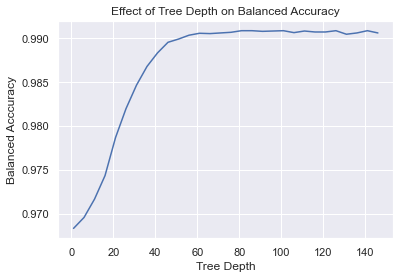

In [94]:
plt.plot(param_arr_depth, ba_arr_depth)
plt.title('Effect of Tree Depth on Balanced Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Balanced Acccuracy')
plt.show()

In [95]:
best_depth = param_arr_depth[np.where(ba_arr_depth == np.max(ba_arr_depth))[0][0]]

In [96]:
print("Balanced Accuracy is maximized at a tree depth of %s. However, so many trees may lead to overfitting, \nespecially since most of the splits are on one feature, current_premium." % best_depth)



Balanced Accuracy is maximized at a tree depth of 81.0. However, so many trees may lead to overfitting, 
especially since most of the splits are on one feature, current_premium.


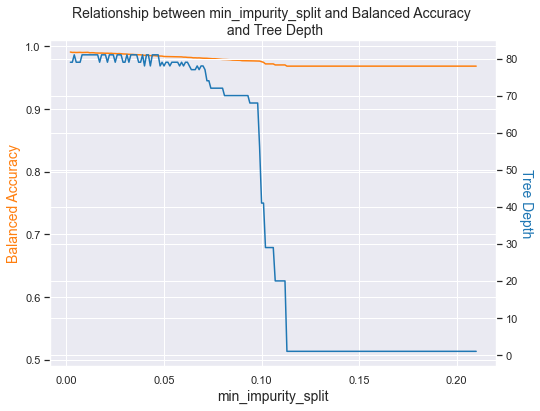

In [97]:
plot_tree_arr(param_arr_imp_split, ba_arr_imp_split, depth_arr_imp_split, param='min_impurity_split')

In [98]:
upper_imp_split = param_arr_imp_split[np.where(depth_arr_imp_split == max(depth_arr_imp_split))[0][-1]]

In [99]:
lower_imp_split = param_arr_imp_split[np.where(depth_arr_imp_split == min(depth_arr_imp_split))[0][-1]]

In [100]:
print("When min_impurity_split <= %f, there are too many splits leading to overfitting. When min_impurity_split > %f, there are too few splits leading to underfitting. Hence, the optimal value for min_impurity_split lies between these two values" %(upper_imp_split, lower_imp_split))



When min_impurity_split <= 0.004000, there are too many splits leading to overfitting. When min_impurity_split > 0.113000, there are too few splits leading to underfitting. Hence, the optimal value for min_impurity_split lies between these two values


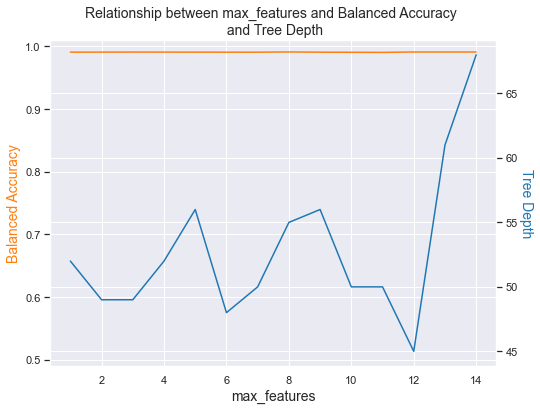

In [101]:
plot_tree_arr(param_arr_features, ba_arr_features, depth_arr_features, param='max_features')

In [102]:
# only the first feature, current_premium, is predictive of the target variable, risk_group
tree.feature_importances_[0]

0.9707214763072

In [103]:
print("Increasing the number of max_features does not affect Balanced Accuracy. That is because only one feature, current_premium, is predictive of the target variable, risk_group, according to the decision tree algorithm.")



Increasing the number of max_features does not affect Balanced Accuracy. That is because only one feature, current_premium, is predictive of the target variable, risk_group, according to the decision tree algorithm.


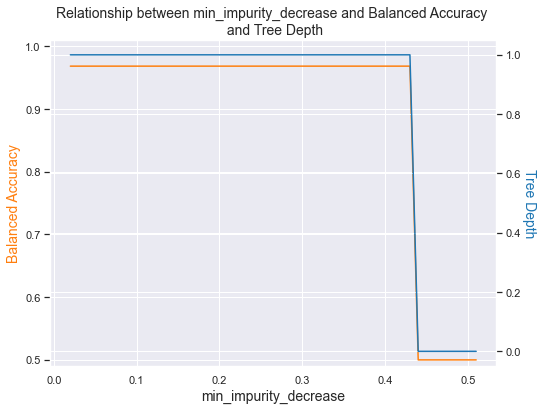

In [104]:
plot_tree_arr(param_arr_imp_dec, ba_arr_imp_dec, depth_arr_imp_dec, param='min_impurity_decrease')

In [105]:
upper_imp_dec = param_arr_imp_dec[np.where(ba_arr_imp_dec == 0.5)[0][-1]+1]

In [106]:
print("A min_impurity_decrease < %f maximizes Balanced Accuracy." % upper_imp_dec)

A min_impurity_decrease < 0.430000 maximizes Balanced Accuracy.


#### Random Forest

In [107]:
param = 'n_estimators'

# set start, stop, step
start = 1
stop = 101
step = 10

n_samples = np.int(round((stop-start)/step, 0))
print(n_samples)

param_arr_est = np.arange(start, stop, step)
ba_arr_est = np.zeros(n_samples)
depth_arr_est = np.zeros(n_samples)

for idx, val in tqdm(enumerate(param_arr_est)):    
    new_forest = RandomForestClassifier(n_estimators=val).fit(X_train, y_train)
    new_forest_y_valid_pred = new_forest.predict(X_valid)
    
    ba_arr_est[idx], param_arr_est[idx], depth_arr_est[idx] = balanced_accuracy_score(y_valid, new_forest_y_valid_pred), val, len(new_forest.estimators_)
    
    

1it [00:00,  6.53it/s]

10


10it [00:52,  5.28s/it]


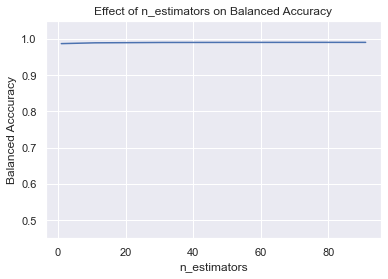

In [108]:
plt.plot(param_arr_est, ba_arr_est)
plt.title('Effect of n_estimators on Balanced Accuracy')
plt.ylim([0.45,1.05])
plt.xlabel('n_estimators')
plt.ylabel('Balanced Acccuracy')
plt.show()

In [109]:
print("Similar to max_features, n_estimators has no effect on Balanced Accuracy.")

Similar to max_features, n_estimators has no effect on Balanced Accuracy.


#### Compute fairness metrics at different values for max_depth

In [110]:
privileged_groups = [{'male': 0, 'middle-aged': 0, 'minority': 0, 'ypc_1': 0}]
unprivileged_groups = [{'male': 1, 'middle-aged': 1, 'minority': 1, 'ypc_1': 1}]

# select dataset
d1 = dataset_test
d2 = dataset_test_pred

In [111]:
bal_acc_arr = []
mean_diff_arr = []
avg_odds_arr = []
disp_imp_arr = []

# needs to be same for original and transformed datasets
param_arr = [1,10,20,30,40,50,60,70,80,90,100,110,120]

for param in tqdm(param_arr):
    # fit a new decision tree
    new_tree = DecisionTreeClassifier(max_depth=param).fit(X_train, y_train)
    new_tree_y_test_pred = new_tree.predict(X_test).reshape(-1,1)
    # update predictions
    d2.labels = new_tree_y_test_pred
    
    metrics_test = ClassificationMetric(d1, d2,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
    
    bal_acc = 0.5*(metrics_test.true_positive_rate()+metrics_test.true_negative_rate())
    bal_acc_arr.append(bal_acc)
    
    mean_diff_arr.append(metrics_test.mean_difference())    
    avg_odds_arr.append(metrics_test.average_odds_difference())
    disp_imp_arr.append(metrics_test.disparate_impact())

100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


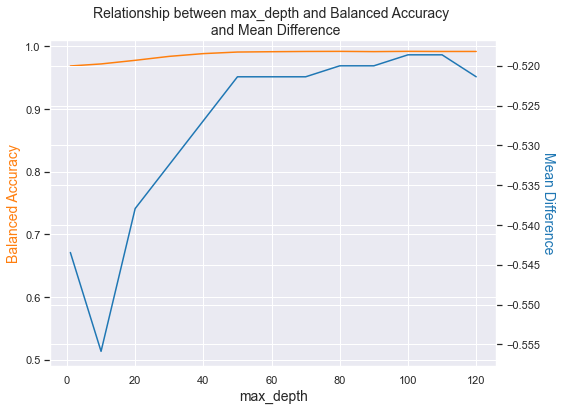

In [112]:
plot_tree_arr(param_arr, bal_acc_arr, mean_diff_arr, param='max_depth', metric_name='Mean Difference')

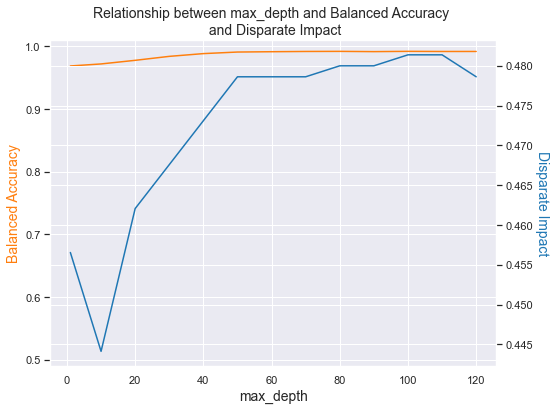

In [113]:
plot_tree_arr(param_arr, bal_acc_arr, disp_imp_arr, param='max_depth', metric_name='Disparate Impact')

#### Train on transformed data

In [114]:
# 70:30 split into train, test
dataset_transf_train, dataset_transf_test = dataset_transf.split([0.7], shuffle=True)

#### Train

In [115]:
X_train_transf = dataset_transf_train.features
y_train_transf = dataset_transf_train.labels.ravel()
w_train_transf = dataset_transf_train.instance_weights.ravel()

tree_transf = DecisionTreeClassifier(random_state=786).fit(X_train, y_train)
tree_y_train_pred = tree_transf.predict(X_train)

#### Test

In [116]:
dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)

X_test_transf = dataset_transf_test_pred.features
y_test_transf = dataset_transf_test_pred.labels

# prob of predicting obs to be in risk group 1
pos_ind = 1
dataset_transf_test_pred.scores = tree_transf.predict_proba(X_test_transf)[:,pos_ind].reshape(-1,1)
y_test_preds_transf = dataset_transf_test_pred.scores

In [117]:
# select dataset
d1 = dataset_transf_test
d2 = dataset_transf_test_pred

In [118]:
bal_acc_arr_transf = []
mean_diff_arr_transf = []
avg_odds_arr_transf = []
disp_imp_arr_transf = []

for param in tqdm(param_arr):
    # fit a new decision tree
    new_tree = DecisionTreeClassifier(max_depth=param).fit(X_train_transf, y_train_transf)
    new_tree_y_test_pred_transf = new_tree.predict(X_test_transf).reshape(-1,1)
    # update predictions
    d2.labels = new_tree_y_test_pred_transf
    
    metrics_test = ClassificationMetric(d1, d2,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
    
    bal_acc = 0.5*(metrics_test.true_positive_rate()+metrics_test.true_negative_rate())
    bal_acc_arr_transf.append(bal_acc)
    
    mean_diff_arr_transf.append(metrics_test.mean_difference())    
    avg_odds_arr_transf.append(metrics_test.average_odds_difference())
    disp_imp_arr_transf.append(metrics_test.disparate_impact())

100%|██████████| 13/13 [00:06<00:00,  2.04it/s]


<a id='tradeoffs'></a>

[Go to top](#main)

### Tradeoffs

In [119]:
def plot_tradeoffs(thresholds_array, accuracy_array, fairness_array, transformed_fairness_array, ax, name):
    ax.plot(thresholds_array, accuracy_array)
    ax.set_xlabel('Decision Tree Depth', fontsize=10.5)
    ax.set_ylabel('Balanced Accuracy', color='b', fontsize=12, labelpad=15)
    # best_class_thresh used as global variable
    # ax.axvline(best_class_thresh, color='k', linestyle=':')

    ax1 = ax.twinx()
    ax1.plot(thresholds_array, fairness_array, color='r', alpha=0.5)
    ax1.set_ylabel(name, color='r', fontsize=12, rotation=-90, labelpad=15)
    ax1.plot(thresholds_array, transformed_fairness_array, color='r')
    
    ax.set_title(name, fontsize=16)
    ax1.legend(['Original', 'Transformed'], loc='lower left')
    ax1.grid(True)

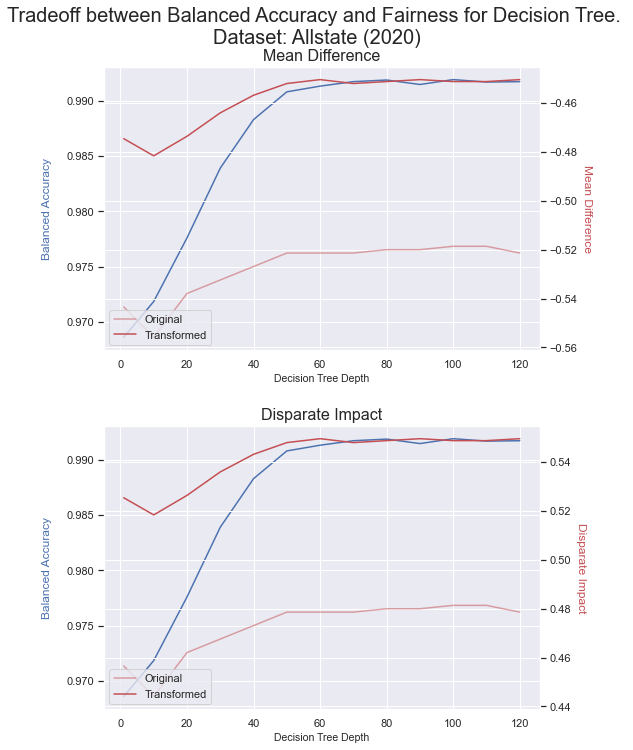

In [120]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(8,10))

plot_tradeoffs(param_arr, bal_acc_arr, mean_diff_arr, mean_diff_arr_transf, ax=ax[0], name='Mean Difference')

plot_tradeoffs(param_arr, bal_acc_arr, disp_imp_arr, disp_imp_arr_transf, ax=ax[1], name='Disparate Impact')

fig.tight_layout(h_pad=2, w_pad=2.5)
fig.suptitle('Tradeoff between Balanced Accuracy and Fairness for Decision Tree. \nDataset: Allstate (2020)', 
             x=0.5, y=1.04, size=20)
plt.show()

[Go to top](#main)